I'll be showing how the HSAR userclass works and comparing the results from OLS and the HSAR in estimating effects for the example data provided.

In [1]:
import hlm
import pysal as ps
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('./test_data/test.csv')

In [3]:
data.head()

,id,u.full,y,x,county
0,0,-0.689048,0.788457,1,1
1,1,-0.689048,0.788457,0,1
2,2,-0.689048,1.064711,0,1
3,3,-0.689048,0.000000,0,1
4,4,-0.847313,1.131402,0,2


In [4]:
y = data[['y']].values
X = data[['x']].values

In [5]:
W = ps.open('./test_data/w_lower.mtx').read()
M = ps.open('./test_data/w_upper.mtx').read()
W.transform = M.transform = 'r'

In [6]:
membership = data[['county']].values - 1

In [7]:
ols = ps.spreg.OLS(y,X,W)

In [8]:
pd.DataFrame(np.hstack((ols.betas, ols.std_err.reshape(ols.betas.shape))),
             columns=['$\\beta$', '$\sigma_\\beta$'])

,$\beta$,$\sigma_\beta$
0,1.326744,0.029721
1,-0.613395,0.072841


Thus, if we just estimate these naively via ols, this is what we get

### The Dong Harris HSAR

The user class will take 1000 samples if you don't pass a `cycles` argument. So, just to show how the user class works, I'll set it up but not start the sampler.

In [9]:
dh = hlm.HSAR(y,X,W,M,membership=membership, n_samples=0, effects_method='chol', spatial_method='grid')

hlm/utils.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)


The public methods and attributes in the sampler are:

In [10]:
[x for x in dir(dh) if not x.startswith('_')]

['M',
 'W',
 'configs',
 'cycles',
 'draw',
 'sample',
 'state',
 'trace',
 'traced_params']

In [11]:
dh.sample(500)

In [12]:
np.hstack(dh.trace.Betas).mean(axis=1)

array([ 1.55313183, -0.68523274])

And so we get a slightly larger constant and an effect that's quite close. The standard errors are:

In [13]:
np.sqrt(np.hstack(dh.trace.Betas).var(axis=1))

array([ 0.11540937,  0.07284761])

Much larger for the constant, but about the same for the estimated effect. 

Now, where this gets nice is that we can make plots of the posterior predictive distributions. We could do this with OLS, too, since each $\hat{\beta} \sim \mathcal{N}(\beta, SE_\hat{\beta})$, but...

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')

/home/ljw/.local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


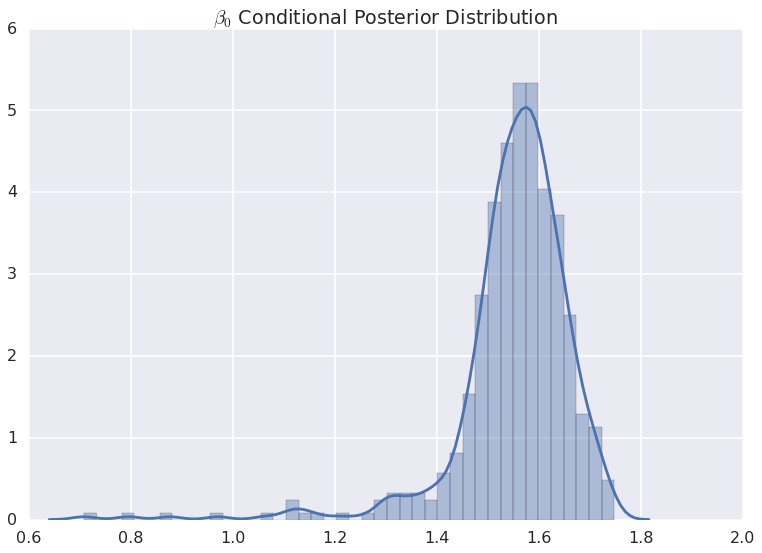

In [15]:
sns.distplot(np.hstack(dh.trace.Betas)[0])
plt.title('$\\beta_0$ Conditional Posterior Distribution')

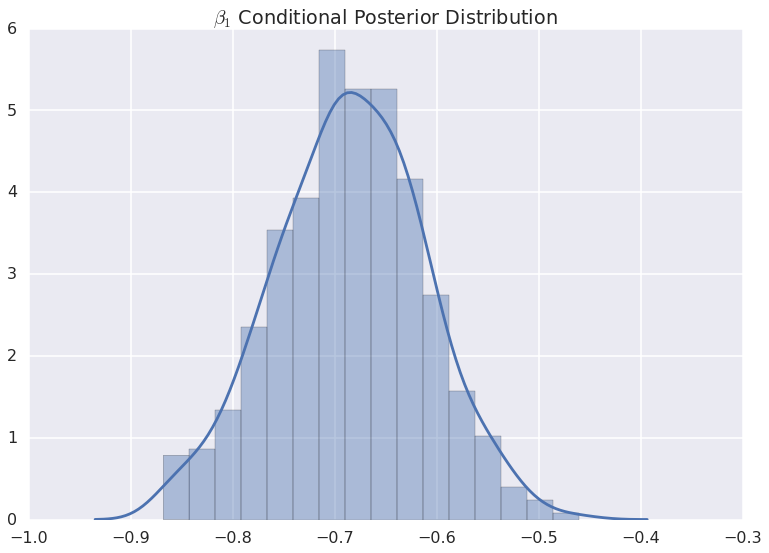

In [16]:
sns.distplot(np.hstack(dh.trace.Betas)[1])
plt.title('$\\beta_1$ Conditional Posterior Distribution')

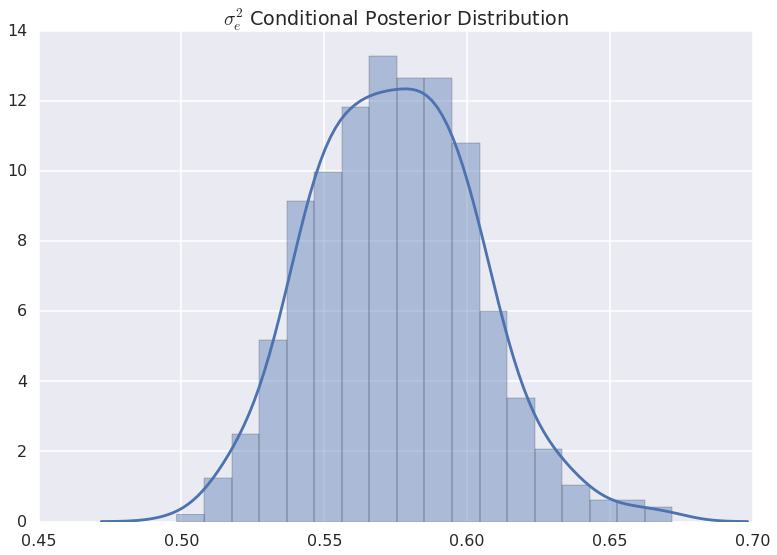

In [17]:
sns.distplot(np.vstack(dh.trace.Sigma2_e))
plt.title('$\\sigma_e^2$ Conditional Posterior Distribution')

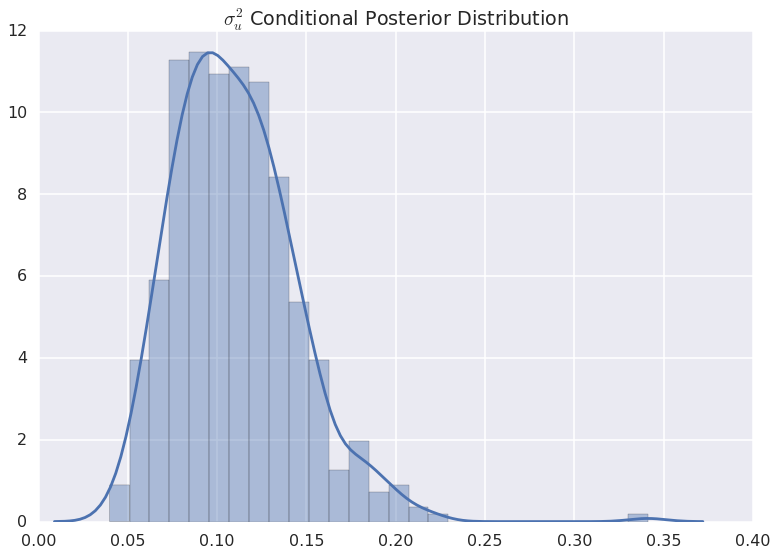

In [18]:
sns.distplot(np.vstack(dh.trace.Sigma2_u))
plt.title('$\\sigma_u^2$ Conditional Posterior Distribution')

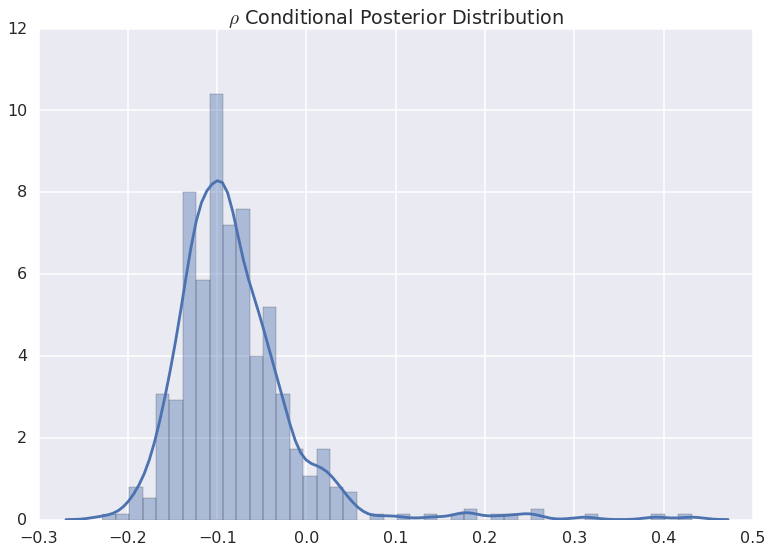

In [19]:
sns.distplot(np.vstack(dh.trace.Rho))
plt.title('$\\rho$ Conditional Posterior Distribution')

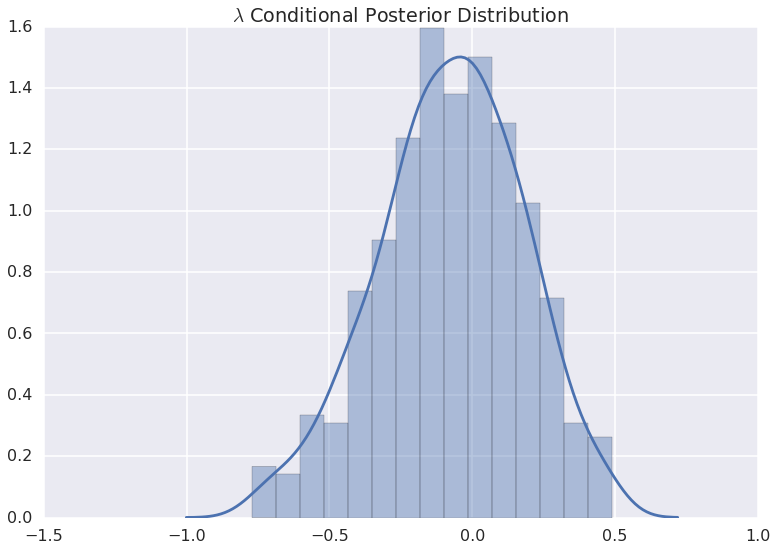

In [21]:
sns.distplot(np.vstack(dh.trace.Lambda))
plt.title('$\\lambda$ Conditional Posterior Distribution')